## Step 0: import
必要なものをインポートする



In [1]:
import os
CODE_DIR = 'psp'

In [2]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Step 1: Select Experiment Type

In [3]:
experiment_type = 'ffhq_encode'

## Step 3: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the image to perform inference on.
While we provide default values to run this script, feel free to change as needed.

In [4]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

In [5]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

We need to verify that the model was downloaded correctly. all of our models should weigh approximately 1.12GB.
Note that if the file weighs several KBs, you most likely encounter a "quota exceeded" error from Google Drive. In that case, you should try downloading the model again after a few hours.

## Step 4: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [6]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [7]:
# ckpt['latent_avg']

In [8]:
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}


In [9]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [10]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [11]:
img_transforms = EXPERIMENT_ARGS['transform']

## 選択

In [12]:
img_pose_dir = 'videos_test/video1/pose_nose/'
img_eye_dir = 'videos_test/video1/syn/eye/'
img_mouth_dir = 'videos_test/video1/syn/mouth/'
img_to_dir = 'videos_test/img/'
for i,file in enumerate(os.listdir(img_to_dir)):
    print(f'{i:2}: {file}')

 0: frame_001.png


In [13]:
inds_to = {0}  # 選択
imgs_to = []
names_to = []
for i,file_name in enumerate(os.listdir(img_to_dir)):
    if i in inds_to:
        names_to.append(os.path.splitext(file_name)[0])
        file_path = img_to_dir+file_name
        img = Image.open(file_path)
        img = img_transforms(img)
        imgs_to.append(img)
imgs_to = torch.stack(imgs_to, dim=0)

In [14]:
imgs_pose = []
imgs_eye = []
imgs_mouth = []
for i,file in enumerate(sorted(os.listdir(img_pose_dir))):
    img = Image.open(f'{img_pose_dir}{i+1:03}.png')
    img = img_transforms(img)
    imgs_pose.append(img)
    img = Image.open(f'{img_eye_dir}{i+1:03}.png')
    img = img_transforms(img)
    imgs_eye.append(img)
    img = Image.open(f'{img_mouth_dir}{i+1:03}.png')
    img = img_transforms(img)
    imgs_mouth.append(img)

imgs_pose = torch.stack(imgs_pose, dim=0)
imgs_eye = torch.stack(imgs_eye, dim=0)
imgs_mouth = torch.stack(imgs_mouth, dim=0)

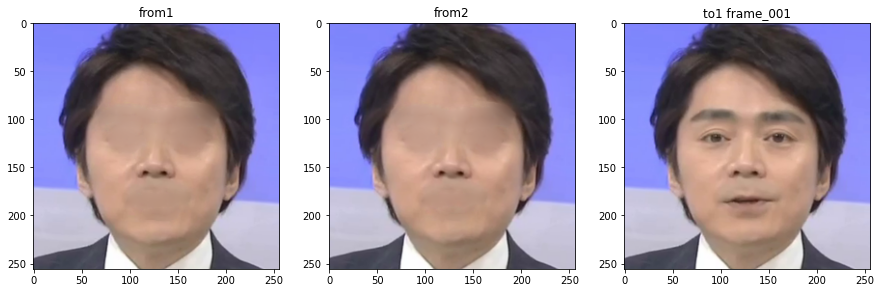

In [15]:
import matplotlib.pyplot as plt

num_to = len(imgs_to)
fig, ax = plt.subplots(1, 2+num_to, figsize=(5*(2+num_to), 5))
for i in range(2):
    ax[i].imshow(imgs_pose[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(f"from{i+1}")

for i in range(num_to):
    ax[i+2].imshow(imgs_to[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+2].set_title(f"to{i+1} {names_to[i]}")

plt.show()

In [16]:
Ws_pose = []
Ws_eye = []
Ws_mouth = []
Ws_to = []
with torch.no_grad():
    for img in imgs_pose:
        w=net.encoder(img.unsqueeze(0).to("cuda").float())
        w=w+ckpt['latent_avg'].to(opts.device).repeat(w.shape[0],1,1)
        Ws_pose.append(w)
    for img in imgs_eye:
        w=net.encoder(img.unsqueeze(0).to("cuda").float())
        w=w+ckpt['latent_avg'].to(opts.device).repeat(w.shape[0],1,1)
        Ws_eye.append(w)
    for img in imgs_mouth:
        w=net.encoder(img.unsqueeze(0).to("cuda").float())
        w=w+ckpt['latent_avg'].to(opts.device).repeat(w.shape[0],1,1)
        Ws_mouth.append(w)
    for img in imgs_to:
        w=net.encoder(img.unsqueeze(0).to("cuda").float())
        w=w+ckpt['latent_avg'].to(opts.device).repeat(w.shape[0],1,1)
        Ws_to.append(w)

In [17]:
w_change_pose = []
w_change_eye = []
w_change_mouth = []

for i in range(len(Ws_pose)):
    w_change_tmp = Ws_pose[i] - Ws_pose[0]
    w_change_pose.append(w_change_tmp)
    w_change_tmp = Ws_eye[i] - Ws_eye[0]
    w_change_eye.append(w_change_tmp)
    w_change_tmp = Ws_mouth[i] - Ws_mouth[0]
    w_change_mouth.append(w_change_tmp)

## 推論

In [20]:
preds = []
preds_pil = []
with torch.no_grad():
    for w in Ws_to:
        preds_tmp = []
        preds_pil_tmp = []
        for i in range(len(w_change_pose)):
            w2 = w + w_change_pose[i]
            pred_image, pred_latent = net.decoder([w2],input_is_latent=True,randomize_noise=False,return_latents=True)
            pred = net.face_pool(pred_image)[0]
            pred_pil = tensor2im(pred)
            preds_tmp.append(pred*0.5+0.5)
            preds_pil_tmp.append(pred_pil)
        preds.append(preds_tmp)
        preds_pil.append(preds_pil_tmp)

## gifの保存

In [21]:
dst_dir = f"videos_test/results_nose/"

preds_pil_q = []
for preds in preds_pil:
    preds_tmp = []
    for pred in preds:
        preds_tmp.append(pred.quantize())
    preds_pil_q.append(preds_tmp)

for i,pred_pil in enumerate(preds_pil_q):
    dst_dir_gif = f"{dst_dir}/"
    if not os.path.exists(dst_dir_gif): os.makedirs(dst_dir_gif)
    file_name = f"result_pose.gif"
    dst_path = dst_dir_gif + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=33,
        loop=0,
    )

## 静止画像（フレーム）の保存

### pose

In [188]:
from torchvision.utils import save_image

dst_dir = f"imgs_test/imgs_parts_transfer/{name_from_dir}"
# select_ind = {0,12,24,36,47,59}
select_ind = {0,2,4,6,8,10}
for i,pred in enumerate(preds_pose):
    dst_dir_parts = f"{dst_dir}/{names_to[i]}/pose/"
    if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
    for j,p in enumerate(pred):
        if j in select_ind:
            file_name = f"result.png"
            save_image(p, file_name, format='PNG')